# Identificação de gênero em Calopsitas
#### Ana Laura Siqueira Mendes

### Importação de bibliotecas

In [2]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D

from sklearn.metrics import precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from scipy.ndimage import zoom
import cv2

### Importando Dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Augmentation

In [4]:
!pip install Augmentor

#### Data Augmentation


In [5]:
import Augmentor

def data_augmentation(input_path, output_path, num_samples):
  pipeline = Augmentor.Pipeline(input_path, output_directory=output_path)

  pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
  pipeline.zoom_random(probability=0.5, percentage_area=0.8)
  pipeline.flip_left_right(probability=0.5)

  pipeline.sample(num_samples)

In [6]:
input_path_train = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender"
output_path_train = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_augmented"

input_path_validation = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_validation"
output_path_validation = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_validation_augmented"

input_path_test = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_test"
output_path_test = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_test_augmented"


data_augmentation(input_path_train, output_path_train, 1000)
data_augmentation(input_path_validation, output_path_validation, 200)
data_augmentation(input_path_test, output_path_test, 200)

Initialised with 43 image(s) found.
Output directory set to /content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_augmented.

Processing <PIL.Image.Image image mode=RGB size=815x922 at 0x7D6C008BAC50>: 100%|██████████| 1000/1000 [02:12<00:00,  7.55 Samples/s]


Initialised with 20 image(s) found.
Output directory set to /content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_validation_augmented.

Processing <PIL.Image.Image image mode=RGBA size=601x770 at 0x7D6C00A657E0>: 100%|██████████| 200/200 [00:36<00:00,  5.43 Samples/s]


Initialised with 10 image(s) found.
Output directory set to /content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_test_augmented.

Processing <PIL.Image.Image image mode=RGBA size=316x423 at 0x7D6C008BB3D0>: 100%|██████████| 200/200 [00:23<00:00,  8.69 Samples/s]


In [7]:
datagen = ImageDataGenerator(rescale=1./255)

base_dir_train = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_augmented"

train_generator = datagen.flow_from_directory(
    base_dir_train,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

base_dir_validation = "/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_validation_augmented"

validation_generator = datagen.flow_from_directory(
    base_dir_validation,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

base_dir_test = '/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_test_augmented'

test_generator = datagen.flow_from_directory(
    base_dir_test,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [8]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
    plt.show()

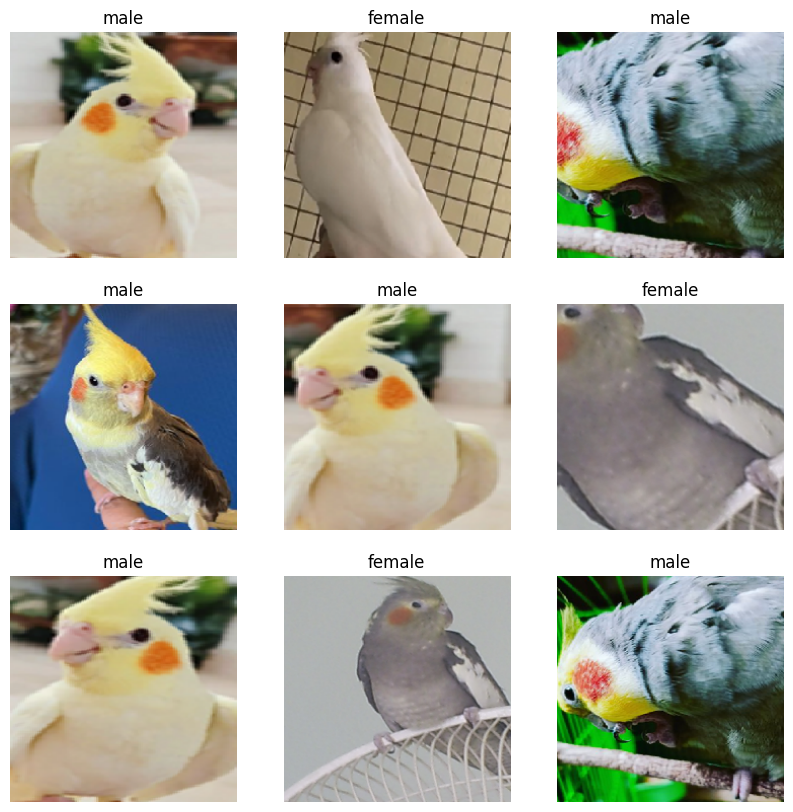

In [9]:

images, labels = test_generator.next()

class_names = list(test_generator.class_indices.keys())

plot_images(images, labels, class_names)

### Implementação do modelo

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 13

### Treino e Teste

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    batch_size=1
)

Epoch 1/100
32/32 [==============================] - 790s 24s/step - loss: 0.6846 - accuracy: 0.5660
Epoch 2/100
32/32 [==============================] - 431s 13s/step - loss: 0.6553 - accuracy: 0.6160
Epoch 3/100
32/32 [==============================] - 430s 13s/step - loss: 0.6284 - accuracy: 0.6345
Epoch 4/100
32/32 [==============================] - 427s 13s/step - loss: 0.6093 - accuracy: 0.6440
Epoch 5/100
32/32 [==============================] - 423s 13s/step - loss: 0.6245 - accuracy: 0.6410
Epoch 6/100
10/32 [========>.....................] - ETA: 4:53 - loss: 0.6059 - accuracy: 0.6469

In [ ]:
def plot_acuracy(history):
    acc = history.history['accuracy']

    plt.plot(acc, label='Acurácia')
    plt.title('Acurácia ao longo das Épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

plot_acuracy(history)

In [ ]:
def evaluate_model(model, test_generator):
    loss, accuracy = model.evaluate(test_generator)
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int)

    precision = precision_score(test_generator.classes, predicted_classes)
    f_score = f1_score(test_generator.classes, predicted_classes)

    print(f'Acurácia do modelo no conjunto de teste: {accuracy}')
    print(f'Precisão do modelo no conjunto de teste: {precision}')
    print(f'F-score do modelo no conjunto de teste: {f_score}')

    cm = confusion_matrix(test_generator.classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão')
    plt.show()

evaluate_model(model, test_generator)

2/2 [==============================] - 1s 124ms/step


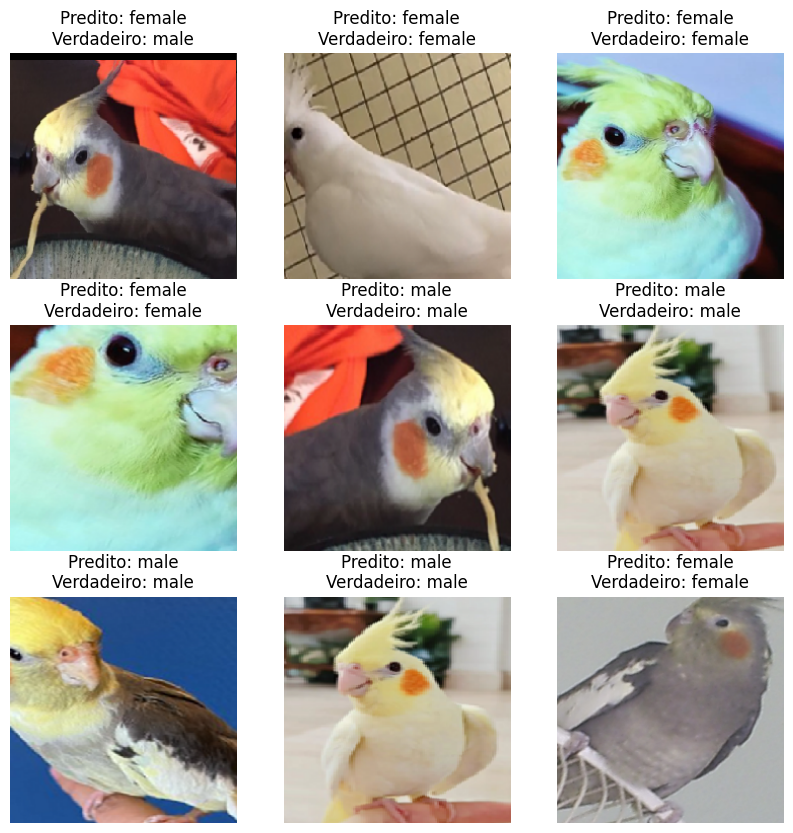

In [ ]:

def plot_predicted_images(model, test_generator, num_images=9):
    images, labels = test_generator.next()

    predictions = model.predict(images)

    class_names = list(test_generator.class_indices.keys())

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_label = class_names[int(round(predictions[i][0]))]
        true_label = class_names[int(labels[i])]
        plt.title(f'Predito: {predicted_label}\nVerdadeiro: {true_label}')
        plt.axis("off")
    plt.show()

plot_predicted_images(model, test_generator)

In [ ]:
def generate_heatmap(model, img_path):

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target_size = (224, 224)
    img = cv2.resize(image, (224, 224))

    X = np.expand_dims(img, axis=0).astype(np.float32)
    X = preprocess_input(X)

    pred = model.predict(X)
    decode_predictions(pred)

    swith tf.GradientTape() as tape:
      last_conv_layer = model.get_layer('conv2d_93')
      iterate = Model([model.inputs], [model.output, last_conv_layer.output])
      model_out, last_conv_layer = iterate(x)
      class_out = model_out[:, np.argmax(model_out[0])]
      grads = tape.gradient(class_out, last_conv_layer)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((8, 8))
    plt.matshow(heatmap)
    plt.show()

generate_heatmap(model, '/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_augmented/female/female_original_1.png_34266976-a6a5-4f8e-81e5-92d55ef995e6.png')
generate_heatmap(model, '/content/drive/MyDrive/artigo_redes_neurais/cockatiel_gender_augmented/male/male_original_1.png_52de089f-9395-4ca8-b42d-f324fe1b18fc.png')

1/1 [==============================] - 2s 2s/step


ValueError: not enough values to unpack (expected 2, got 1)